In [1]:
import torch
import argparse
from torch.utils.data import DataLoader
from torch import nn, optim
from torchvision.transforms import transforms
from torch.utils.data import Dataset
import PIL.Image as Image
import os
import matplotlib.pyplot as plt

In [2]:
torch.manual_seed(1)    # reproducible

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, input):
        return self.conv(input)


class Unet(nn.Module):
    def __init__(self,in_ch,out_ch):
        super(Unet, self).__init__()
        self.n_channels = in_ch
        self.n_classes = out_ch
        self.conv1 = DoubleConv(in_ch, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64,out_ch, 1)

    def forward(self,x):
        c1=self.conv1(x)
        p1=self.pool1(c1)
        c2=self.conv2(p1)
        p2=self.pool2(c2)
        c3=self.conv3(p2)
        p3=self.pool3(c3)
        c4=self.conv4(p3)
        p4=self.pool4(c4)
        c5=self.conv5(p4)
        up_6= self.up6(c5)
        merge6 = torch.cat([up_6, c4], dim=1)
        c6=self.conv6(merge6)
        up_7=self.up7(c6)
        merge7 = torch.cat([up_7, c3], dim=1)
        c7=self.conv7(merge7)
        up_8=self.up8(c7)
        merge8 = torch.cat([up_8, c2], dim=1)
        c8=self.conv8(merge8)
        up_9=self.up9(c8)
        merge9=torch.cat([up_9,c1],dim=1)
        c9=self.conv9(merge9)
        c10=self.conv10(c9)
        #out = nn.Sigmoid()(c10)
        return c10

In [5]:
def make_dataset(root):
    imgs=[]
    n=len(os.listdir(root))//2
    for i in range(n):
        img=os.path.join(root,"%03d.png"%i)
        mask=os.path.join(root,"%03d_mask.png"%i)
        imgs.append((img,mask))
    return imgs


class LiverDataset(Dataset):
    def __init__(self, root, transform=None, target_transform=None):
        imgs = make_dataset(root)
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        x_path, y_path = self.imgs[index]
        img_x = Image.open(x_path)
        img_y = Image.open(y_path)
        if self.transform is not None:
            img_x = self.transform(img_x)
        if self.target_transform is not None:
            img_y = self.target_transform(img_y)
        return img_x, img_y

    def __len__(self):
        return len(self.imgs)

In [6]:
x_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

y_transforms = transforms.Compose([
    transforms.Resize(size = 256),
    transforms.ToTensor(),
])

In [7]:
# liver_dataset = LiverDataset("u_net_liver/data/data/val", transform=x_transforms,target_transform=y_transforms)

In [8]:
def train_model(model, criterion, optimizer, dataload, num_epochs=20):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        dt_size = len(dataload.dataset)
        epoch_loss = 0
        step = 0
        for x, y in dataload:
            step += 1
            inputs = x.to(device)
            labels = y.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
            print("%d/%d,train_loss:%0.3f" % (step, (dt_size - 1) // dataload.batch_size + 1, loss.item()))
        print("epoch %d loss:%0.3f" % (epoch, epoch_loss/step))
    torch.save(model.state_dict(), 'weights_%d.pth' % epoch)
    return model

In [9]:
model = Unet(3, 1).to(device)
batch_size = 1
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())
liver_dataset = LiverDataset("u_net_liver/data/data/train",transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
train_model(model, criterion, optimizer, dataloaders, num_epochs=5)

Epoch 0/4
----------
1/400,train_loss:0.791
2/400,train_loss:0.715
3/400,train_loss:0.656
4/400,train_loss:0.599
5/400,train_loss:0.653
6/400,train_loss:0.555
7/400,train_loss:0.536
8/400,train_loss:0.602
9/400,train_loss:0.541
10/400,train_loss:0.604
11/400,train_loss:0.485
12/400,train_loss:0.505
13/400,train_loss:0.476
14/400,train_loss:0.438
15/400,train_loss:0.441
16/400,train_loss:0.414
17/400,train_loss:0.560
18/400,train_loss:0.481
19/400,train_loss:0.499
20/400,train_loss:0.406
21/400,train_loss:0.424
22/400,train_loss:0.398
23/400,train_loss:0.457
24/400,train_loss:0.407
25/400,train_loss:0.391
26/400,train_loss:0.374
27/400,train_loss:0.431
28/400,train_loss:0.386
29/400,train_loss:0.368
30/400,train_loss:0.375
31/400,train_loss:0.353
32/400,train_loss:0.361
33/400,train_loss:0.337
34/400,train_loss:0.409
35/400,train_loss:0.330
36/400,train_loss:0.341
37/400,train_loss:0.356
38/400,train_loss:0.379
39/400,train_loss:0.316
40/400,train_loss:0.334
41/400,train_loss:0.344
42/4

333/400,train_loss:0.034
334/400,train_loss:0.045
335/400,train_loss:0.041
336/400,train_loss:0.044
337/400,train_loss:0.041
338/400,train_loss:0.044
339/400,train_loss:0.032
340/400,train_loss:0.052
341/400,train_loss:0.045
342/400,train_loss:0.038
343/400,train_loss:0.024
344/400,train_loss:0.057
345/400,train_loss:0.051
346/400,train_loss:0.033
347/400,train_loss:0.024
348/400,train_loss:0.048
349/400,train_loss:0.050
350/400,train_loss:0.029
351/400,train_loss:0.038
352/400,train_loss:0.052
353/400,train_loss:0.037
354/400,train_loss:0.025
355/400,train_loss:0.034
356/400,train_loss:0.047
357/400,train_loss:0.089
358/400,train_loss:0.074
359/400,train_loss:0.048
360/400,train_loss:0.037
361/400,train_loss:0.030
362/400,train_loss:0.037
363/400,train_loss:0.031
364/400,train_loss:0.043
365/400,train_loss:0.037
366/400,train_loss:0.040
367/400,train_loss:0.042
368/400,train_loss:0.022
369/400,train_loss:0.031
370/400,train_loss:0.035
371/400,train_loss:0.034
372/400,train_loss:0.100


264/400,train_loss:0.038
265/400,train_loss:0.029
266/400,train_loss:0.024
267/400,train_loss:0.023
268/400,train_loss:0.022
269/400,train_loss:0.035
270/400,train_loss:0.011
271/400,train_loss:0.020
272/400,train_loss:0.031
273/400,train_loss:0.027
274/400,train_loss:0.027
275/400,train_loss:0.038
276/400,train_loss:0.022
277/400,train_loss:0.033
278/400,train_loss:0.037
279/400,train_loss:0.019
280/400,train_loss:0.016
281/400,train_loss:0.032
282/400,train_loss:0.015
283/400,train_loss:0.011
284/400,train_loss:0.020
285/400,train_loss:0.051
286/400,train_loss:0.029
287/400,train_loss:0.009
288/400,train_loss:0.027
289/400,train_loss:0.034
290/400,train_loss:0.010
291/400,train_loss:0.036
292/400,train_loss:0.029
293/400,train_loss:0.012
294/400,train_loss:0.022
295/400,train_loss:0.021
296/400,train_loss:0.025
297/400,train_loss:0.019
298/400,train_loss:0.033
299/400,train_loss:0.027
300/400,train_loss:0.020
301/400,train_loss:0.020
302/400,train_loss:0.025
303/400,train_loss:0.021


195/400,train_loss:0.011
196/400,train_loss:0.041
197/400,train_loss:0.019
198/400,train_loss:0.013
199/400,train_loss:0.019
200/400,train_loss:0.016
201/400,train_loss:0.028
202/400,train_loss:0.013
203/400,train_loss:0.022
204/400,train_loss:0.014
205/400,train_loss:0.022
206/400,train_loss:0.023
207/400,train_loss:0.014
208/400,train_loss:0.025
209/400,train_loss:0.018
210/400,train_loss:0.021
211/400,train_loss:0.026
212/400,train_loss:0.008
213/400,train_loss:0.011
214/400,train_loss:0.026
215/400,train_loss:0.028
216/400,train_loss:0.015
217/400,train_loss:0.027
218/400,train_loss:0.018
219/400,train_loss:0.027
220/400,train_loss:0.047
221/400,train_loss:0.023
222/400,train_loss:0.023
223/400,train_loss:0.006
224/400,train_loss:0.051
225/400,train_loss:0.008
226/400,train_loss:0.045
227/400,train_loss:0.036
228/400,train_loss:0.032
229/400,train_loss:0.025
230/400,train_loss:0.023
231/400,train_loss:0.028
232/400,train_loss:0.030
233/400,train_loss:0.032
234/400,train_loss:0.022


126/400,train_loss:0.012
127/400,train_loss:0.018
128/400,train_loss:0.021
129/400,train_loss:0.016
130/400,train_loss:0.024
131/400,train_loss:0.012
132/400,train_loss:0.019
133/400,train_loss:0.012
134/400,train_loss:0.020
135/400,train_loss:0.008
136/400,train_loss:0.018
137/400,train_loss:0.010
138/400,train_loss:0.006
139/400,train_loss:0.019
140/400,train_loss:0.005
141/400,train_loss:0.016
142/400,train_loss:0.025
143/400,train_loss:0.016
144/400,train_loss:0.037
145/400,train_loss:0.018
146/400,train_loss:0.010
147/400,train_loss:0.017
148/400,train_loss:0.007
149/400,train_loss:0.021
150/400,train_loss:0.006
151/400,train_loss:0.015
152/400,train_loss:0.024
153/400,train_loss:0.029
154/400,train_loss:0.036
155/400,train_loss:0.022
156/400,train_loss:0.027
157/400,train_loss:0.013
158/400,train_loss:0.009
159/400,train_loss:0.018
160/400,train_loss:0.008
161/400,train_loss:0.017
162/400,train_loss:0.014
163/400,train_loss:0.018
164/400,train_loss:0.024
165/400,train_loss:0.019


55/400,train_loss:0.019
56/400,train_loss:0.022
57/400,train_loss:0.010
58/400,train_loss:0.037
59/400,train_loss:0.006
60/400,train_loss:0.012
61/400,train_loss:0.008
62/400,train_loss:0.020
63/400,train_loss:0.007
64/400,train_loss:0.012
65/400,train_loss:0.009
66/400,train_loss:0.010
67/400,train_loss:0.009
68/400,train_loss:0.009
69/400,train_loss:0.020
70/400,train_loss:0.008
71/400,train_loss:0.007
72/400,train_loss:0.029
73/400,train_loss:0.020
74/400,train_loss:0.013
75/400,train_loss:0.014
76/400,train_loss:0.011
77/400,train_loss:0.006
78/400,train_loss:0.004
79/400,train_loss:0.016
80/400,train_loss:0.007
81/400,train_loss:0.011
82/400,train_loss:0.021
83/400,train_loss:0.015
84/400,train_loss:0.011
85/400,train_loss:0.011
86/400,train_loss:0.014
87/400,train_loss:0.015
88/400,train_loss:0.014
89/400,train_loss:0.010
90/400,train_loss:0.013
91/400,train_loss:0.025
92/400,train_loss:0.012
93/400,train_loss:0.010
94/400,train_loss:0.005
95/400,train_loss:0.018
96/400,train_los

385/400,train_loss:0.019
386/400,train_loss:0.015
387/400,train_loss:0.016
388/400,train_loss:0.014
389/400,train_loss:0.012
390/400,train_loss:0.005
391/400,train_loss:0.016
392/400,train_loss:0.015
393/400,train_loss:0.008
394/400,train_loss:0.016
395/400,train_loss:0.010
396/400,train_loss:0.016
397/400,train_loss:0.009
398/400,train_loss:0.010
399/400,train_loss:0.016
400/400,train_loss:0.015
epoch 4 loss:0.013


Unet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool2): MaxPool

In [10]:
model = model.cpu()

In [11]:
liver_dataset = LiverDataset("u_net_liver/data/data/val", transform=x_transforms,target_transform=y_transforms)
dataloaders = DataLoader(liver_dataset, batch_size=1)
# model.eval()

In [12]:
model.eval()

Unet(
  (conv1): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): DoubleConv(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace)
    )
  )
  (pool2): MaxPool

In [13]:
def meanIOU_per_image(y_pred, y_true):
    '''
    Calculate the IOU, averaged across images
    '''
    import numpy as np
    y_pred = y_pred.astype('bool')
    y_true = y_true.astype('bool')
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    
    return np.sum(intersection) / np.sum(union)

In [14]:
IoU = 0
n = 0
with torch.no_grad():
    for x, target in dataloaders:
        n = n + 1
        y = model(x)
        y_pred = torch.squeeze(y).numpy() > 0.5
        y_true = torch.squeeze(target).numpy()
        # print(meanIOU_per_image(y_pred, y_true))
        IoU = IoU + meanIOU_per_image(y_pred, y_true)
print(IoU/n)

0.7737273318699383


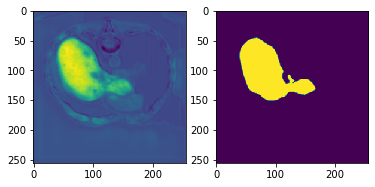

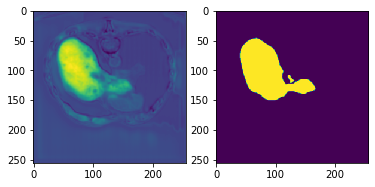

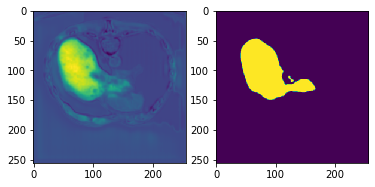

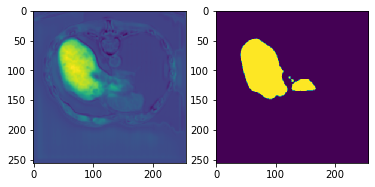

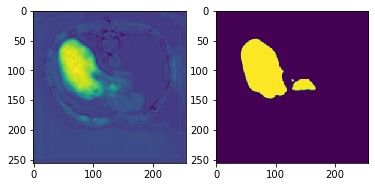

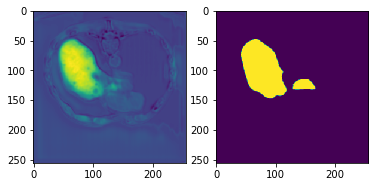

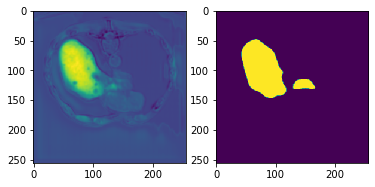

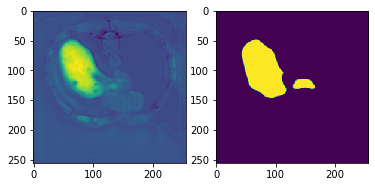

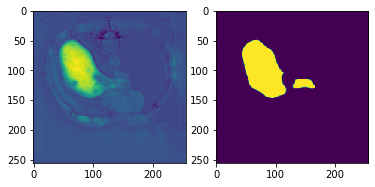

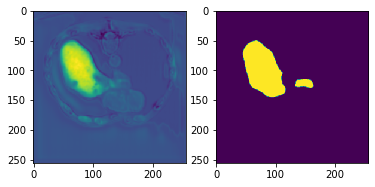

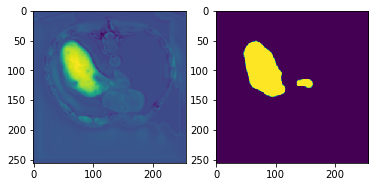

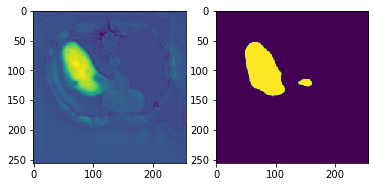

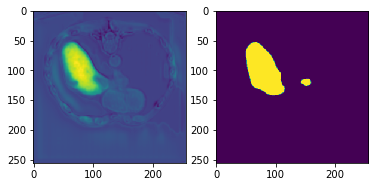

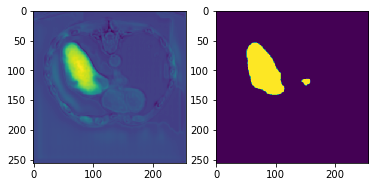

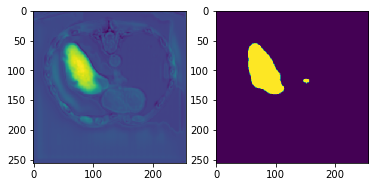

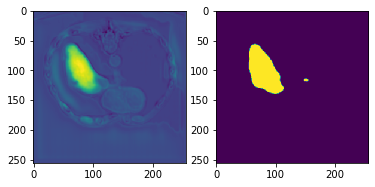

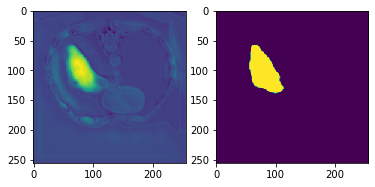

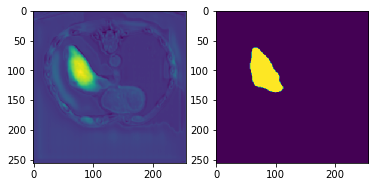

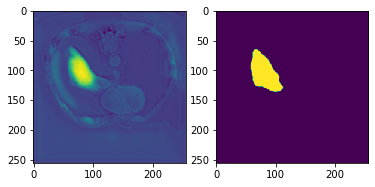

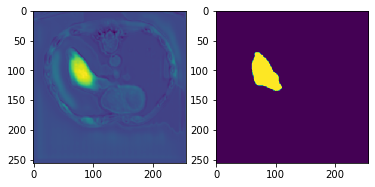

In [15]:
plt.ion()
with torch.no_grad():
    for x,label in dataloaders:
        y=model(x)
        img_y=torch.squeeze(y).numpy()
        img_label = torch.squeeze(label).numpy()  
        plt.figure()
        plt.subplot(1,2,1)
        plt.imshow(img_y)
        plt.subplot(1,2,2)
        plt.imshow(img_label)
        plt.pause(0.01)
    plt.show()